# 2D Navier Stokes fluid-simulation 

In order to create a 2D fluid simulation we used the OpenFOAM 2D lid-driven cavity tutorial as a test-case.

This simulation uses the icoFoam solver with a fixed viscosity term.

The boundary condition on the top of the cavity creates a pressure gradient causing the fluid to swirl.

The goal of this notebook is to load the OpenFOAM data into a NumPy object using the XXXX library created by XXXX.

Once the data is loaded in a python object we will use Matplotlib and its quiver and animation features to visualize the fluid flow.

This data will then act as a test case for a PINN used to model 2D navier stokes fluid flow.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import Ofpp as ofpp

In [31]:
#Load the openfoam data for single time-step initially
U = ofpp.parse_internal_field("../../data/openfoam-cavity-re100/U")
print(U.shape)
print(U[0])

p = ofpp.parse_internal_field("../../data/openfoam-cavity-re100/p")
print(p.shape)
print(p[0])

(400, 3)
[ 0.00167347 -0.00167633  0.        ]
(400,)
-1.97181e-07


In [32]:
#Seperate velocity vector into seperate direction components
u = U[:,0]
v = U[:,1]
# not interested as doing 2D simulation w = U[:,2] 

#Create a velocity magnitude for plotting later
U_mag = np.sqrt(u**2 + v**2)

print(u.shape, y.shape)

(400,) (20,)


We will Use this code as inspiration for an animated subplot

https://stackoverflow.com/questions/29832055/animated-subplots-using-matplotlib

2 rows and 2 columns

Use pcolormesh(X, Y, Z) over imshow

- [0,0] u component of velocity, coloured (like imshow; somewhere saw better option mentioned), with quiver showing velocity direction and coloured by magnitude (sqrt(u\*\*2 + u\*\*2))
- [0,1] u component of velocity, coloured (like imshow; somewhere saw better option mentioned), with quiver showing velocity magnitude and coloured by magnitude (sqrt(u\*\*2 + u\*\*2))
- [1,0] u component of velocity, coloured (like imshow; somewhere saw better option mentioned), with quiver showing velocity magnitude and coloured by magnitude (sqrt(u\*\*2 + u\*\*2))
- [1,1] pressure component of velocity, coloured (like imshow; somewhere saw better option mentioned)

Then animate these plots so they progress through each timestep to show evolution of the fluid

Option to play on loop if possible.

In [33]:
x = np.linspace(0,20,20)
X, Y = np.meshgrid(x,x)

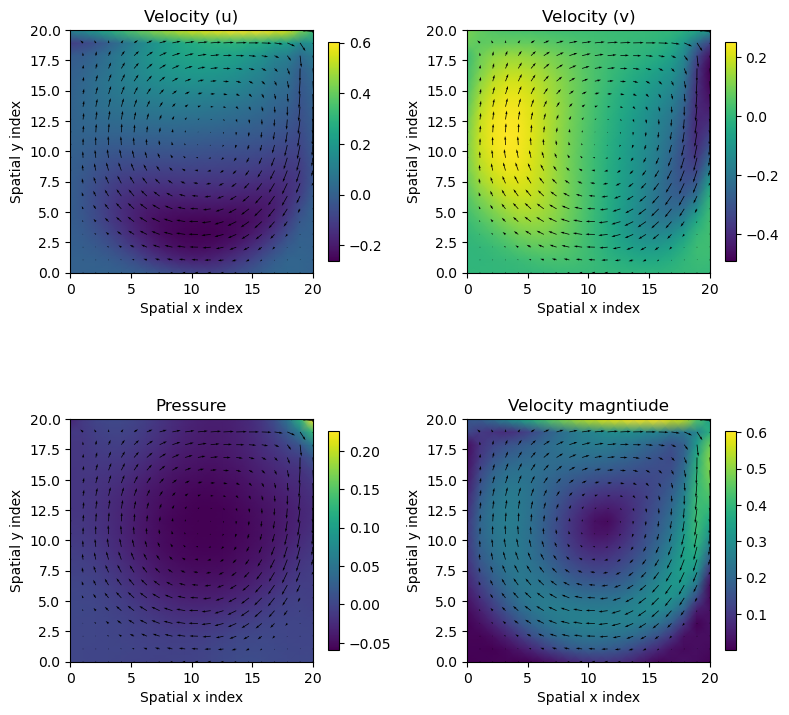

In [61]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
ax[0][0].pcolormesh(X, Y, u.reshape(X.shape), shading='gouraud')
fig.colorbar(ax[0][0].pcolormesh(X, Y, u.reshape(X.shape), shading='gouraud'), shrink=0.6, orientation='vertical')
ax[0][0].quiver(X,Y,u.reshape(X.shape),v.reshape(X.shape))
ax[0][0].set_title("Velocity (u)")
ax[0][0].set_ylabel("Spatial y index")
ax[0][0].set_xlabel("Spatial x index")
ax[0][0].set_box_aspect(1)

ax[0][1].pcolormesh(X, Y, v.reshape(X.shape), shading='gouraud')
fig.colorbar(ax[0][1].pcolormesh(X, Y, v.reshape(X.shape), shading='gouraud'), shrink=0.6, orientation='vertical')
ax[0][1].quiver(X,Y,u.reshape(X.shape),v.reshape(X.shape))
ax[0][1].set_title("Velocity (v)")
ax[0][1].set_ylabel("Spatial y index")
ax[0][1].set_xlabel("Spatial x index")
ax[0][1].set_box_aspect(1)

ax[1][0].pcolormesh(X, Y, p.reshape(X.shape), shading='gouraud')
fig.colorbar(ax[1][0].pcolormesh(X, Y, p.reshape(X.shape), shading='gouraud'), shrink=0.6, orientation='vertical')
ax[1][0].quiver(X,Y,u.reshape(X.shape),v.reshape(X.shape),)
ax[1][0].set_title("Pressure")
ax[1][0].set_ylabel("Spatial y index")
ax[1][0].set_xlabel("Spatial x index")
ax[1][0].set_box_aspect(1)

ax[1][1].pcolormesh(X, Y, U_mag.reshape(X.shape), shading='gouraud')
fig.colorbar(ax[1][1].pcolormesh(X, Y, U_mag.reshape(X.shape), shading='gouraud'), shrink=0.6, orientation='vertical')
ax[1][1].quiver(X,Y,u.reshape(X.shape),v.reshape(X.shape),)
ax[1][1].set_title("Velocity magntiude")
ax[1][1].set_ylabel("Spatial y index")
ax[1][1].set_xlabel("Spatial x index")
ax[1][1].set_box_aspect(1)

fig.tight_layout()

plt.show()